<a href="https://colab.research.google.com/github/Manjeeray/BookRecommenderSystem-Collaborative-ContentBased/blob/main/UrbanAudio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import os
import IPython.display as ipd
import random
import shutil
import pickle
from tqdm import tqdm
import soundfile as sf
from scipy.io import wavfile

In [2]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.utils import to_categorical
from keras import optimizers
from sklearn.model_selection import train_test_split
from keras.layers import BatchNormalization
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
metadata = pd.read_csv('/content/drive/MyDrive/metadata (1)/UrbanSound8K.csv')
metadata

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn


In [5]:
missing_values = metadata.isnull()
missing_values.sum()

slice_file_name    0
fsID               0
start              0
end                0
salience           0
fold               0
classID            0
class              0
dtype: int64

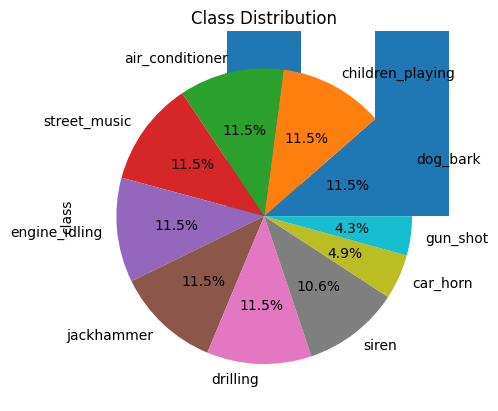

In [6]:
# Get the count of each label
label_counts = metadata['class'].value_counts()

# Plot the count of each label using a histogram
label_counts.plot(kind='bar', title='Class Distribution')

# Plot the count of each label using a pie chart
label_counts.plot(kind='pie', title='Class Distribution', autopct='%1.1f%%')

plt.show()

In [7]:
audio_file = '/content/drive/MyDrive/audio/fold1/103074-7-1-3.wav'

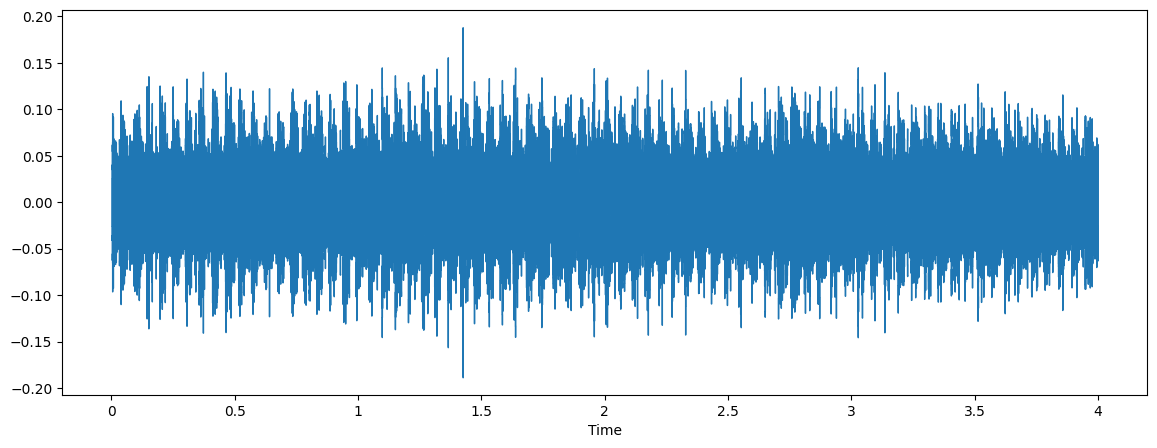

In [8]:
data, sample_rate=librosa.load(audio_file)
plt.figure(figsize=(14,5))
librosa.display.waveshow(data, sr=sample_rate)
ipd.Audio(audio_file)

In [9]:
signal, sr = librosa.load(audio_file)
mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13)

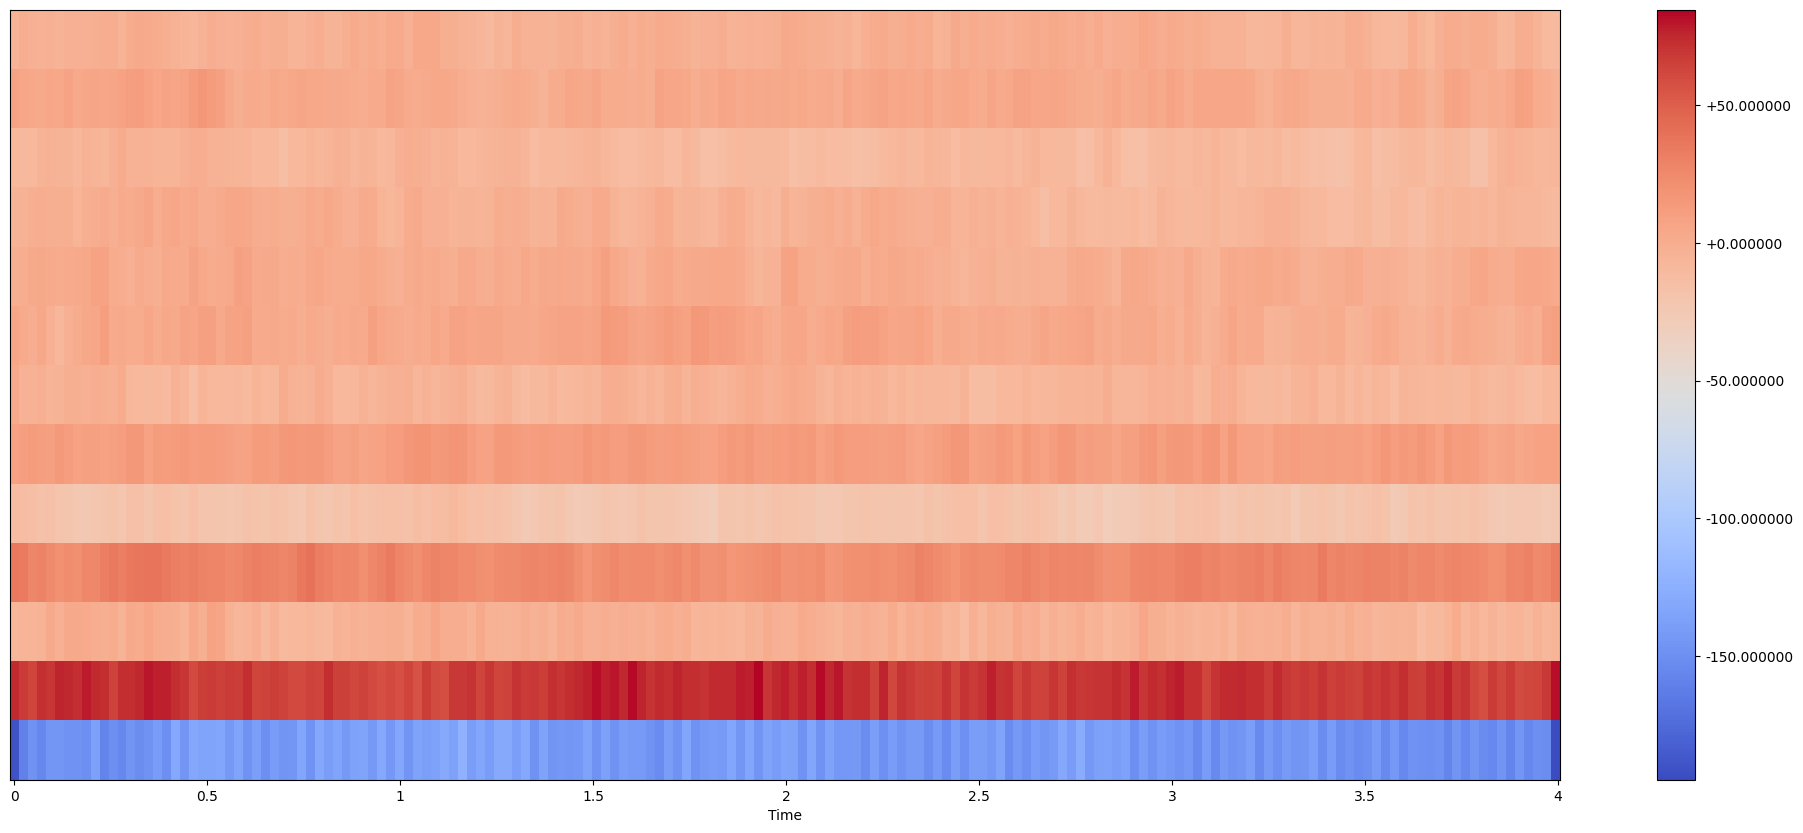

In [10]:
#visualize MFCCs
plt.figure(figsize=(25,10))
librosa.display.specshow(mfccs,
                         x_axis="time",
                         sr=sr)
plt.colorbar(format="%+2f")
plt.show()

**EXTRCATING MFCC FEATURES**

In [11]:
data_folder = '/content/drive/MyDrive/audio'

In [12]:
def feature_extractor(file):
  audio,sample_rate = librosa.load(file_name)
  mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13)
  mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
  return mfccs_scaled_features

In [13]:
extracted_features = []
for index_num, row in tqdm(metadata.iterrows()):
  file_name = os.path.join(os.path.abspath(data_folder), 'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
  final_class_labels = row["class"]
  data = feature_extractor(file_name)
  extracted_features.append([data,final_class_labels])


3554it [02:41, 21.23it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
8323it [06:08, 31.39it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(
8732it [06:21, 22.86it/s]


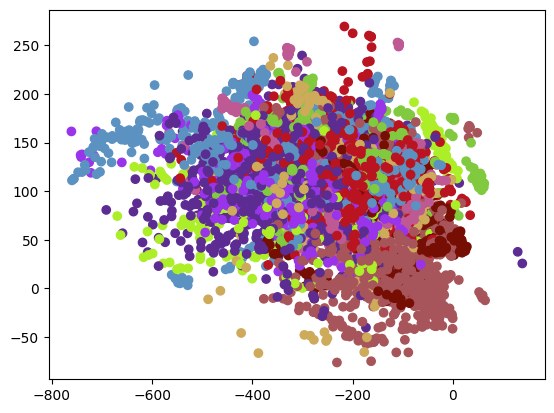

In [41]:
# Extract features and labels into numpy arrays
X = np.array([x[0] for x in extracted_features])
y = np.array([x[1] for x in extracted_features])

# Flatten the feature matrices
X_flat = X.reshape(X.shape[0], -1)

# Define a list of unique classes
classes = metadata['class'].unique()

# Map each class to a unique color
class_to_color = {c: np.random.rand(3,) for c in classes}

# Create a list of colors for each data point
colors = [class_to_color[label] for _, label in extracted_features]

# Plot the features as a scatter plot
plt.scatter(X_flat[:, 0], X_flat[:, 1], c=colors)
plt.show()

In [15]:
mfcc_df = pd.DataFrame(extracted_features, columns=['f','l'])
mfcc_df

,f,l
0,"[-211.93698, 62.581215, -122.813156, -60.74529...",dog_bark
1,"[-417.0052, 99.336624, -42.995586, 51.073326, ...",children_playing
2,"[-452.39316, 112.36253, -37.578075, 43.195866,...",children_playing
3,"[-406.47922, 91.1966, -25.043556, 42.78452, 11...",children_playing
4,"[-439.63873, 103.86223, -42.658787, 50.690285,...",children_playing
...,...,...
8727,"[-391.3721, 125.36239, -40.634056, 25.899754, ...",car_horn
8728,"[-339.42715, 76.409096, -35.30988, 41.984035, ...",car_horn
8729,"[-297.31534, 102.09026, -36.75108, 26.816488, ...",car_horn
8730,"[-336.92386, 115.3139, -44.84709, 24.968985, -...",car_horn


In [47]:
#converting list of features into array
x = np.array(mfcc_df['f'].tolist())
y = np.array(mfcc_df['l'].tolist())

In [48]:
#converting categorical variables into numerical representations
y = np.array(pd.get_dummies(y))

**BUILDING ANN**

In [18]:
#split the data
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size= 0.2, random_state=True, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [19]:
num_classes = 10
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(13,)))
model.add(Dropout(0.2))

model.add(Dense(200, activation='relu', input_shape=(13,)))
model.add(Dropout(0.2))

model.add(Dense(100, activation='relu', input_shape=(13,)))
model.add(Dropout(0.2))


#output layer
model.add(Dense(10, activation = "softmax"))


# compile the model
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               1400      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               20200     
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               20100     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                1

In [21]:
acc = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32)

Epoch 1/100
175/175 [==============================] - 2s 4ms/step - loss: 5.2645 - accuracy: 0.1407 - val_loss: 2.2472 - val_accuracy: 0.1238
Epoch 2/100
175/175 [==============================] - 1s 3ms/step - loss: 2.2815 - accuracy: 0.1387 - val_loss: 2.1988 - val_accuracy: 0.1811
Epoch 3/100
175/175 [==============================] - 0s 3ms/step - loss: 2.2196 - accuracy: 0.1777 - val_loss: 2.1495 - val_accuracy: 0.2105
Epoch 4/100
175/175 [==============================] - 1s 3ms/step - loss: 2.1613 - accuracy: 0.2049 - val_loss: 2.0672 - val_accuracy: 0.2534
Epoch 5/100
175/175 [==============================] - 0s 3ms/step - loss: 2.1066 - accuracy: 0.2419 - val_loss: 1.9479 - val_accuracy: 0.3250
Epoch 6/100
175/175 [==============================] - 1s 3ms/step - loss: 2.0197 - accuracy: 0.2793 - val_loss: 1.7869 - val_accuracy: 0.3529
Epoch 7/100
175/175 [==============================] - 0s 3ms/step - loss: 1.9374 - accuracy: 0.3049 - val_loss: 1.7695 - val_accuracy: 0.3873

In [22]:
def plot_history(acc):
  fig, axs = plt.subplots(2)

  #create accuracy subplot
  axs[0].plot(acc.history["accuracy"], label="train accuracy")
  axs[0].plot(acc.history["val_accuracy"], label="test accuracy")
  axs[0].set_ylabel("Accuracy")
  axs[0].legend(loc="lower right")
  axs[0].set_title("Accuracy eval")

  #create loss subplot
  axs[1].plot(acc.history["loss"], label="train error")
  axs[1].plot(acc.history["val_loss"], label="test error")
  axs[1].set_ylabel("Error")
  axs[1].set_ylabel("Epoch")
  axs[1].legend(loc="upper right")
  axs[1].set_title("Error eval")

  plt.show()


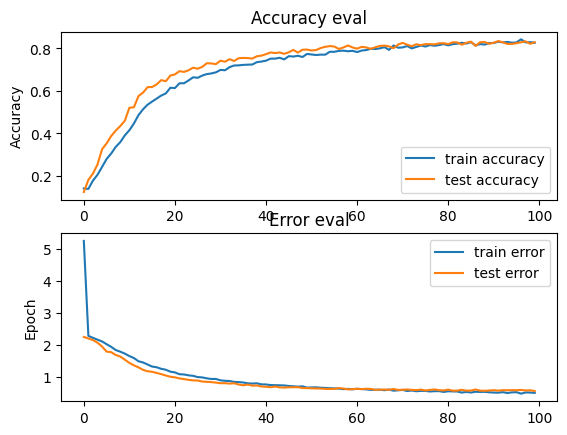

In [23]:
plot_history(acc)

**Feature extrcation for CNN. Had to pad the features since CNN need equal length features**

In [24]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras import optimizers
from sklearn.model_selection import train_test_split
from keras.layers import BatchNormalization

In [25]:

# Set the path to the UrbanSound8K dataset
US8K_PATH = '/content/drive/MyDrive/audio'

# Load the metadata CSV file
metadata = pd.read_csv(os.path.join(US8K_PATH, '/content/drive/MyDrive/metadata/UrbanSound8K.csv'))

# Define the number of MFCCs to extract
MFCC_NUM = 13

# Define the maximum length of MFCCs
MFCC_MAX_LEN = 128

# Define the sampling rate
SAMPLING_RATE = 22050

# Define a function to convert a sound wave to MFCCs
def wav2mfcc(wave, max_len=MFCC_MAX_LEN):
    mfcc = librosa.feature.mfcc(y=wave, n_mfcc=MFCC_NUM, sr=SAMPLING_RATE)

    # If maximum length exceeds mfcc lengths then pad the remaining ones
    if (max_len > mfcc.shape[1]):
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')

    # Else cutoff the remaining parts
    else:
        mfcc = mfcc[:, :max_len]
    
    return mfcc




In [26]:
# Load the audio files and their corresponding labels
X = []
y = []

for index_num, row in tqdm(metadata.iterrows()):
    labels = row['classID']
    file_name = os.path.join(os.path.abspath(data_folder), 'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    wave, sr = librosa.load(file_name, mono=True, sr=SAMPLING_RATE)
    mfcc = wav2mfcc(wave)
    X.append(mfcc)
    y.append(labels)

# Convert the data to numpy arrays
X = np.array(X)
y = np.array(y)

# Print the shapes of the data arrays
print('X shape:', X.shape)
print('y shape:', y.shape)

3552it [02:23, 29.04it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
8321it [05:49, 44.32it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
8327it [05:49, 47.91it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(
8732it [06:03, 24.04it/s]


X shape: (8732, 13, 128)
y shape: (8732,)


In [42]:
 y = np.array(pd.get_dummies(y))

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.2, random_state=True, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [29]:
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)


In [30]:
num_classes = 10
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=X_train[0].shape))
model.add(MaxPooling2D(pool_size=(3, 3), strides = (2,2), padding ='same'))
model.add(BatchNormalization())

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=X_train[0].shape))
model.add(MaxPooling2D(pool_size=(3, 3), strides = (2,2), padding ='same'))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(2, 2), activation='relu', input_shape=X_train[0].shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides = (2,2), padding ='same'))
model.add(BatchNormalization())

#flatten layer
model.add(Flatten())
model.add(Dense(64, activation = "relu"))
model.add(Dropout(0.4))

#output layer
model.add(Dense(10, activation = "softmax"))

optimizer = keras.optimizers.Adam(learning_rate=0.001)

# compile the model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [31]:
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_accuracy',patience = 5)
acc = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, callbacks=[early_stop])

Epoch 1/50
175/175 [==============================] - 14s 72ms/step - loss: 1.7519 - accuracy: 0.4243 - val_loss: 1.5324 - val_accuracy: 0.4817
Epoch 2/50
175/175 [==============================] - 13s 74ms/step - loss: 1.2929 - accuracy: 0.5564 - val_loss: 1.4429 - val_accuracy: 0.5562
Epoch 3/50
175/175 [==============================] - 15s 87ms/step - loss: 1.1016 - accuracy: 0.6190 - val_loss: 1.0504 - val_accuracy: 0.6292
Epoch 4/50
175/175 [==============================] - 13s 76ms/step - loss: 0.9518 - accuracy: 0.6768 - val_loss: 0.9483 - val_accuracy: 0.6750
Epoch 5/50
175/175 [==============================] - 13s 73ms/step - loss: 0.8678 - accuracy: 0.6981 - val_loss: 0.8556 - val_accuracy: 0.7087
Epoch 6/50
175/175 [==============================] - 13s 74ms/step - loss: 0.7861 - accuracy: 0.7309 - val_loss: 0.8293 - val_accuracy: 0.7373
Epoch 7/50
175/175 [==============================] - 12s 68ms/step - loss: 0.7383 - accuracy: 0.7452 - val_loss: 0.7886 - val_accuracy:

In [32]:
def plot_history(acc):
  fig, axs = plt.subplots(2)

  #create accuracy subplot
  axs[0].plot(acc.history["accuracy"], label="train accuracy")
  axs[0].plot(acc.history["val_accuracy"], label="test accuracy")
  axs[0].set_ylabel("Accuracy")
  axs[0].legend(loc="lower right")
  axs[0].set_title("Accuracy eval")

  #create loss subplot
  axs[1].plot(acc.history["loss"], label="train error")
  axs[1].plot(acc.history["val_loss"], label="test error")
  axs[1].set_ylabel("Error")
  axs[1].set_ylabel("Epoch")
  axs[1].legend(loc="upper right")
  axs[1].set_title("Error eval")

  plt.show()

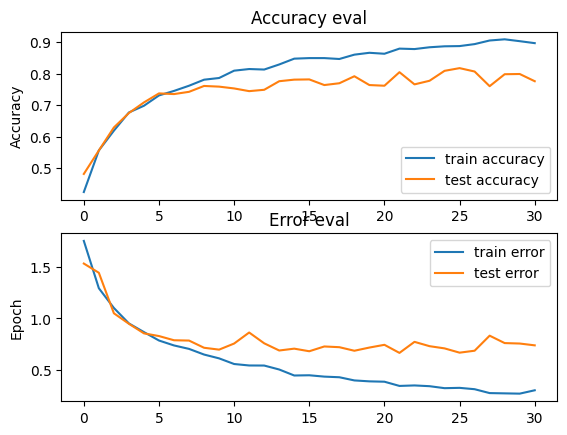

In [33]:
plot_history(acc)

**LSTM **

In [46]:
from keras.models import Sequential
from keras import regularizers
from keras.layers import LSTM, Dropout, Dense

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.2, random_state=True, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [51]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [53]:
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

In [86]:
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(units=128))
model.add(Dropout(0.3))
model.add(Dense(units=10, activation='softmax', kernel_regularizer=regularizers.l2(0.01)))
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer= 'Adam', metrics=['accuracy']) 

In [87]:
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_accuracy',patience = 3)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64, callbacks=[early_stop])

Epoch 1/50
88/88 [==============================] - 13s 87ms/step - loss: 2.0686 - accuracy: 0.3155 - val_loss: 1.8112 - val_accuracy: 0.3955
Epoch 2/50
88/88 [==============================] - 6s 63ms/step - loss: 1.7073 - accuracy: 0.4381 - val_loss: 1.5838 - val_accuracy: 0.4717
Epoch 3/50
88/88 [==============================] - 7s 85ms/step - loss: 1.5278 - accuracy: 0.5082 - val_loss: 1.4889 - val_accuracy: 0.5192
Epoch 4/50
88/88 [==============================] - 6s 63ms/step - loss: 1.4060 - accuracy: 0.5487 - val_loss: 1.4474 - val_accuracy: 0.5369
Epoch 5/50
88/88 [==============================] - 8s 88ms/step - loss: 1.3196 - accuracy: 0.5795 - val_loss: 1.3010 - val_accuracy: 0.5764
Epoch 6/50
88/88 [==============================] - 6s 66ms/step - loss: 1.2318 - accuracy: 0.6131 - val_loss: 1.2354 - val_accuracy: 0.6033
Epoch 7/50
88/88 [==============================] - 8s 87ms/step - loss: 1.1457 - accuracy: 0.6484 - val_loss: 1.1392 - val_accuracy: 0.6468
Epoch 8/50
8

In [65]:
def plot_history(history):
  fig, axs = plt.subplots(2)

  #create accuracy subplot
  axs[0].plot(history.history["accuracy"], label="train accuracy")
  axs[0].plot(history.history["val_accuracy"], label="test accuracy")
  axs[0].set_ylabel("Accuracy")
  axs[0].legend(loc="lower right")
  axs[0].set_title("Accuracy eval")

  #create loss subplot
  axs[1].plot(history.history["loss"], label="train error")
  axs[1].plot(history.history["val_loss"], label="test error")
  axs[1].set_ylabel("Error")
  axs[1].set_ylabel("Epoch")
  axs[1].legend(loc="upper right")
  axs[1].set_title("Error eval")

  plt.show()


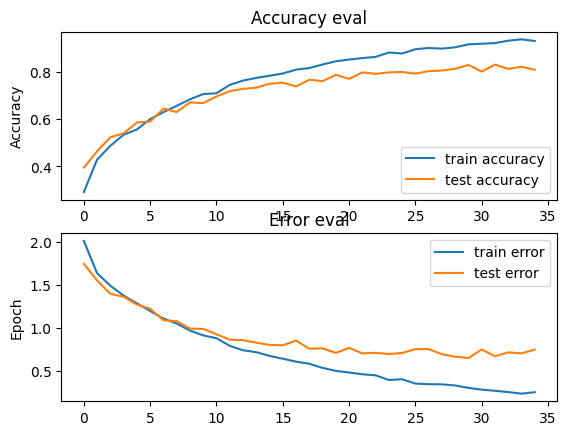

In [81]:
plot_history(history)

In [75]:
train_loss, train_acc =model.evaluate(X_train, y_train,verbose =2)
test_loss, test_acc =model.evaluate(X_test, y_test,verbose =2)

175/175 - 2s - loss: 0.2121 - accuracy: 0.9501 - 2s/epoch - 12ms/step
55/55 - 1s - loss: 0.6670 - accuracy: 0.8168 - 744ms/epoch - 14ms/step
